In [3]:
# RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [4]:
from __future__ import annotations
import numpy as np
import seaborn as sns
import os
import datetime
#import cv2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
%matplotlib inline

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, MaxPooling1D,\
Dropout, Flatten, Activation, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, Precision, Recall, FalsePositives, \
FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2

In [6]:
tf.keras.backend.clear_session() # For easy reset of NB state
print(tf.__version__) # see > 2.0.0 here
from tf_keras_vis.utils import print_gpus
print_gpus()

2.0.0
0 GPUs


In [7]:
seed = 109
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
# install this if you want to play around with Tensorboard
#!pip install tf-keras-vis tensorflow
%load_ext tensorboard

In [9]:
# remove old logs
!rm -rf ./logs/

x_train shape: (60000, 28, 28) x_test shape: (10000, 28, 28)
y_train shape: (60000,) y_test shape: (10000,)


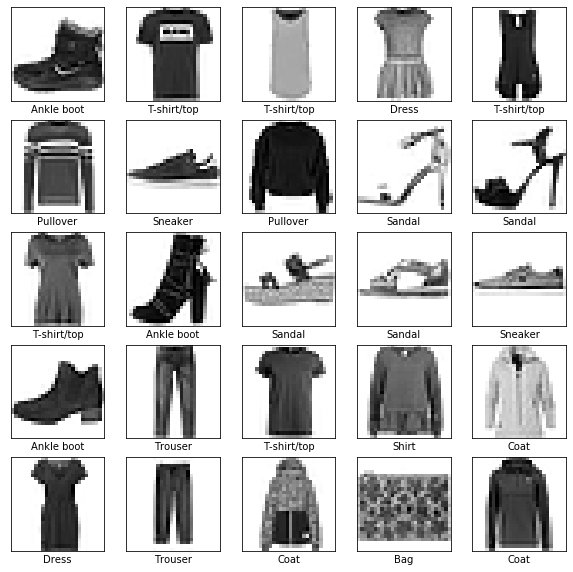

In [10]:
# AE on Fashion MNIST

fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalize
x_train, x_test = x_train/255., x_test/255.

print(f'x_train shape: {x_train.shape} x_test shape: {x_test.shape}')
print(f'y_train shape: {y_train.shape} y_test shape: {y_test.shape}')

# class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize = (10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary) #'gray')
    # cmap = gray provides black background
    plt.xlabel(class_names[y_train[i]])

Text(0.5, 0, 'Pullover')

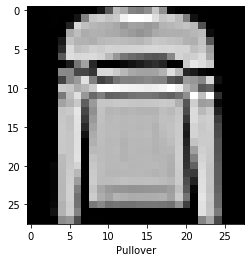

In [11]:
# choose 1 image to look at
i = 5
plt.imshow(x_train[i], cmap = 'gray') #plt.cm.binary)
plt.xlabel(class_names[y_train[i]])

In [12]:
# calculate dimensionality of the dataset and flatten for PCA

n_samples, h, w = x_train.shape
print(f'We have {n_samples} images each with height {h} & width {w}')
print(f'Data dimensionality: {h*w}')
print(f'x_train shape: {x_train.shape}, and x_test shape: {x_test.shape}')
print(f'y_train shape: {x_train.shape}, and y_test shape: {y_test.shape}')

# Flatten images for PCA
x_train_flat = x_train.reshape(x_train.shape[0],-1)
x_test_flat = x_test.reshape(x_test.shape[0],-1)
print(f'x_train flat shape: {x_train_flat.shape}, and x_test flat shape: {x_test_flat.shape}')


We have 60000 images each with height 28 & width 28
Data dimensionality: 784
x_train shape: (60000, 28, 28), and x_test shape: (10000, 28, 28)
y_train shape: (60000, 28, 28), and y_test shape: (10000,)
x_train flat shape: (60000, 784), and x_test flat shape: (10000, 784)


In [13]:
from sklearn.decomposition import PCA

# Find 1st 2 PCAs
n_components = 2
# only fit & not fit_transform since we only want to get the PCs

pca = PCA(n_components = n_components).fit(x_train_flat)

# take a look at the principle components
print(f'Shape of the 2 component vector (1st & 2nd): {pca.components_.shape}')
print(f'Shape of the 1st PC: {pca.components_[0].shape}')
print(f'Shape of the 2nd PC: {pca.components_[1].shape}\n')

# reshape so they resemble images
eigenclothes = pca.components_.reshape((n_components, h, w))
print(f'Shape of reshaped eigenclothes: {eigenclothes.shape}')
print(f'Shape of the 1st article of eigenclothing: {eigenclothes[0].shape}')

Shape of the 2 component vector (1st & 2nd): (2, 784)
Shape of the 1st PC: (784,)
Shape of the 2nd PC: (784,)

Shape of reshaped eigenclothes: (2, 28, 28)
Shape of the 1st article of eigenclothing: (28, 28)


Text(0.5, 0, '2nd PC')

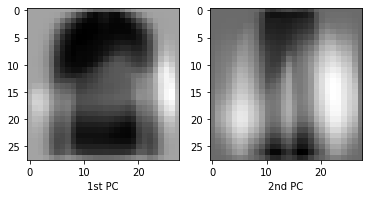

In [14]:
# Show reshaped principal components
f, ax = plt.subplots(1,2)
ax[0].imshow(eigenclothes[0], plt.cm.binary)
ax[0].set_xlabel("1st PC")
ax[1].imshow(eigenclothes[1], cmap = 'gray')
ax[1].set_xlabel('2nd PC')

In [15]:
pca.explained_variance_.sum()

31.922016138297245

In [16]:
# use .transform since we are projecting the x_train onto the PC dimensions
x_train_pca = pca.transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

In [17]:
x_train_pca.shape, x_train_pca[1:5,0].shape

((60000, 2), (4,))

In [18]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


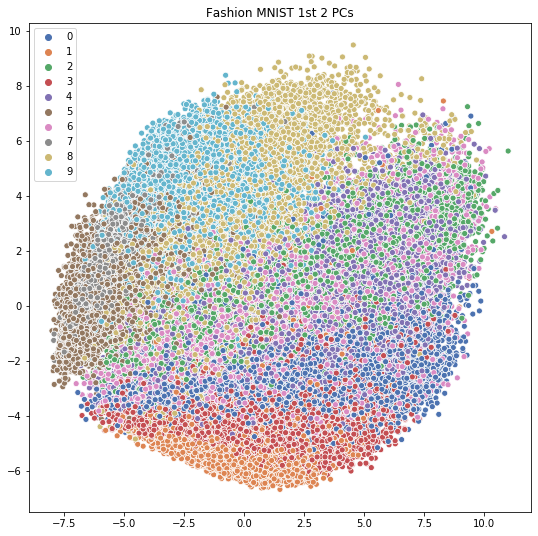

In [19]:
fig, ax1 = plt.subplots(1,1, figsize = (9,9))
sns.scatterplot(x = x_train_pca[:,0], y = x_train_pca[:,1], hue = y_train,
               palette = sns.color_palette('deep', 10), ax = ax1)
ax1.set_title("Fashion MNIST 1st 2 PCs");

<a id=part2></a>
## Part2: Denoise Images using AEs

In [ ]:
from imgaug import augmenters

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - ^C
failed with repodata from current_repodata.json, will retry with next repodata source.

CondaError: KeyboardInterrupt

